In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', None)
%matplotlib inline


In [3]:
#Exclude "NA" from list of na_values
na_values = ["","#N/A","#N/A N/A","#NA","-1.#IND","-1.#QNAN","-NaN","-nan","1.#IND","1.#QNAN","<NA>","N/A","NULL","NaN","n/a","nan","null"]

## See the columns

In [6]:
data_files = [
    "demographics.csv",
    "epidemiology.csv",
    "hospitalizations.csv",
    "vaccinations.csv"
]

for file in data_files:
    chunker = pd.read_csv(f'./data/{file}', chunksize=1000, keep_default_na=False, na_values=na_values)
    print("\n\033[1m", file.replace(".csv", "").title(), "\033[0m")
    for chunck in chunker: 
        print(chunck.head()) 
        break


 Demographics 
  location_key  population  population_male  population_female  \
0           AD       77265          58625.0            55581.0   
1           AE     9890400        6836349.0          3054051.0   
2           AF    38928341       19976265.0         18952076.0   
3       AF_BAL     1509183              NaN                NaN   
4       AF_BAM      495557              NaN                NaN   

   population_rural  population_urban  population_largest_city  \
0            9269.0           67873.0                      NaN   
1         1290785.0         8479744.0                2833079.0   
2        28244481.0         9797273.0                4114030.0   
3               NaN               NaN                      NaN   
4               NaN               NaN                      NaN   

   population_clustered  population_density  human_development_index  \
0                   NaN             164.394                    0.858   
1             5914068.0             118.306   

## Select data

In [9]:
for file in data_files:
    countries = pd.DataFrame([])
    chunker = pd.read_csv(f'./data/{file}', chunksize=1000, keep_default_na=False, na_values=na_values)
    print("\n\033[1m", file.replace(".csv", "").title(), "\033[0m")
    for chunk in chunker: 
        #select only countries
        new_chunk = chunk[chunk['location_key'].str.contains("_")==False]
        countries = pd.concat([countries,new_chunk])
    key = file.replace(".csv", "")
    countries.to_pickle(f'data/binaries/{key}')




 Demographics 

 Epidemiology 

 Hospitalizations 

 Vaccinations 


In [18]:
data_files_json = [
    "health.json",
    "economy.json"
]

for file in data_files_json:
    countries = pd.DataFrame([])
    data_json = pd.read_json(f'./data/{file}', orient='split')
    print("\n\033[1m", file.replace(".json", "").title(), "\033[0m")
    countries = data_json[data_json['location_key'].str.contains("_")==False]
    key = file.replace(".json", "")
    countries.to_pickle(f'data/binaries/{key}')


 Health 

 Economy 


## Create the dictionary

Save to pickle just in case we need to correct something, to not run the chunker again

In [146]:
data_files = [
    "demographics.csv",
    "epidemiology.csv",
    "hospitalizations.csv",
    "vaccinations.csv"
]

In [147]:
data = {}

data_files.extend(data_files_json)
print(data_files)

for file in data_files:
    key = file.replace('.json','').replace('.csv','')
    data[key] = pd.read_pickle(f"data/binaries/{key}")
    data[key].reset_index()


['demographics.csv', 'epidemiology.csv', 'hospitalizations.csv', 'vaccinations.csv', 'health.json', 'economy.json']


In [148]:
data.keys()

dict_keys(['demographics', 'epidemiology', 'hospitalizations', 'vaccinations', 'health', 'economy'])

## Drop columns

In [149]:
columns = {
    'demographics': ['location_key', 'population', 'population_density' ,'human_development_index'],
    'epidemiology' : ['date','location_key','new_confirmed','new_deceased','new_recovered','new_tested'],
    'health': ['location_key', 'smoking_prevalence', 'diabetes_prevalence', 'infant_mortality_rate', \
          'adult_male_mortality_rate', 'adult_female_mortality_rate', 'pollution_mortality_rate', 'comorbidity_mortality_rate'],
    'economy': ['location_key', 'gdp_usd', 'gdp_per_capita_usd'],
    'vaccinations': ['date','location_key','new_persons_vaccinated','new_persons_fully_vaccinated','new_vaccine_doses_administered'],
    'hospitalizations': ['date','location_key','new_hospitalized_patients','new_intensive_care_patients' ,'new_ventilator_patients']
}

#datasets with date
for key,values in data.items():
    data[key] = data[key].loc[:,columns[key]]
    print("\n\033[1m", key.title(), "\033[0m")
    print(data[key].info())


    



 Demographics 
<class 'pandas.core.frame.DataFrame'>
Index: 246 entries, 0 to 21688
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   location_key             246 non-null    object 
 1   population               245 non-null    float64
 2   population_density       230 non-null    float64
 3   human_development_index  186 non-null    float64
dtypes: float64(3), object(1)
memory usage: 9.6+ KB
None

 Epidemiology 
<class 'pandas.core.frame.DataFrame'>
Index: 227879 entries, 0 to 12525824
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   date           227879 non-null  object 
 1   location_key   227879 non-null  object 
 2   new_confirmed  227786 non-null  float64
 3   new_deceased   227611 non-null  float64
 4   new_recovered  15712 non-null   float64
 5   new_tested     77270 non-null   float64
dtypes: float64(4),

### Convert date from object to date

In [150]:
#datasets with date
for key,values in data.items():
    print("\n\033[1m", key.title(), "\033[0m")
    data[key] = data[key].astype({'location_key':'string'})
    if data[key].columns.isin(['date']).any():
        #convert to date
        data[key]['date']= pd.to_datetime(data[key]['date'], format='%Y-%m-%d', errors='coerce')
        #remove data before 2020 
        data[key] = data[key][data[key]['date'].dt.year >= 2020]
        #add year
        data[key]['year'] = data[key]['date'].dt.strftime('%Y')
        data[key]['year'] = pd.to_numeric(data[key]['year'], errors='coerce')
        #add month
        data[key]['month'] = data[key]['date'].dt.strftime('%m')
        data[key]['month'] = pd.to_numeric(data[key]['month'], errors='coerce')
        data[key].drop(columns = ['date'], inplace=True)
    print(data[key].info())


    


 Demographics 
<class 'pandas.core.frame.DataFrame'>
Index: 246 entries, 0 to 21688
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   location_key             246 non-null    string 
 1   population               245 non-null    float64
 2   population_density       230 non-null    float64
 3   human_development_index  186 non-null    float64
dtypes: float64(3), string(1)
memory usage: 9.6 KB
None

 Epidemiology 
<class 'pandas.core.frame.DataFrame'>
Index: 227877 entries, 0 to 12525824
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   location_key   227877 non-null  string 
 1   new_confirmed  227786 non-null  float64
 2   new_deceased   227611 non-null  float64
 3   new_recovered  15712 non-null   float64
 4   new_tested     77268 non-null   float64
 5   year           227877 non-null  int64  
 6   month          

## Missing values

In [151]:
for key,values in data.items():
    print("\n\033[1m", key.title(), "\033[0m")
    print(data[key].isna().sum())
    


 Demographics 
location_key                0
population                  1
population_density         16
human_development_index    60
dtype: int64

 Epidemiology 
location_key          0
new_confirmed        91
new_deceased        266
new_recovered    212165
new_tested       150609
year                  0
month                 0
dtype: int64

 Hospitalizations 
location_key                       0
new_hospitalized_patients       5386
new_intensive_care_patients    12231
new_ventilator_patients        17376
year                               0
month                              0
dtype: int64

 Vaccinations 
location_key                         0
new_persons_vaccinated            1297
new_persons_fully_vaccinated      3375
new_vaccine_doses_administered     952
year                                 0
month                                0
dtype: int64

 Health 
location_key                    0
smoking_prevalence             64
diabetes_prevalence             1
infant_mortality_rate   

## Demographics

In [152]:
data['demographics'][data['demographics']['population'].isna()]

,location_key,population,population_density,human_development_index
18096,SJ,NaN,NaN,NaN


In [153]:
data['demographics'][data['demographics']['population_density'].isna()] #show NaN rows

,location_key,population,population_density,human_development_index
41,AN,197041.0,NaN,NaN
43,AQ,4400.0,NaN,NaN
6393,BV,0.0,NaN,NaN
6411,CC,596.0,NaN,NaN
7521,CX,1843.0,NaN,NaN
9812,GG,63276.0,NaN,NaN
9820,GS,30.0,NaN,NaN
9848,HM,0.0,NaN,NaN
12236,IO,4000.0,NaN,NaN
12382,JE,105500.0,NaN,NaN


In [154]:
#Define a dictionary for population densities of select countries
pop_density = {'CC':41.97, 'CX':13.65, 'GG':1020.58, 'JE':882.11, 'NF':63.24, 'PN':1.06, 'UM':3.86, 'XK':172.96}

In [155]:
data['demographics']['population_density'].fillna(data['demographics']['location_key'].map(pop_density), inplace=True)
data['demographics'].iloc[[37,52,79,108,159,176,227,240]]

,location_key,population,population_density,human_development_index
6411,CC,596.0,41.97,NaN
7521,CX,1843.0,13.65,NaN
9812,GG,63276.0,1020.58,NaN
12382,JE,105500.0,882.11,NaN
15072,NF,2188.0,63.24,NaN
17890,PN,50.0,1.06,NaN
18282,UM,190.0,3.86,NaN
21622,XK,1883018.0,172.96,NaN


In [156]:
#Define a dictionary for human development indices of select countries
country = ['AS','AW','BM','CK','FK','FM','FO','GE','GF','GG','GI','GU','IE','IM','JE','KP','KY','MC','MK','MO',\
           'MP','MQ','MS','NF','NR','NU','PR','PS','RE','SH','SM','SO','SX','TC','TK','TV','VG','VI','WF','XK','YT']
hdi = [0.827,0.908,0.981,0.829,0.933,0.628,0.950,0.812,0.793,0.985,0.961,0.901,0.945,0.849,0.985,0.733,0.877,0.956,0.770,0.909,\
        0.875,0.848,0.821,0.958,0.721,0.794,0.845,0.690,0.843,0.797,0.853,0.364,0.702,0.873,0.750,0.641,0.945,0.894,0.763,0.787,0.781]
hdi_country = dict(zip(country,hdi))
print(hdi_country)

{'AS': 0.827, 'AW': 0.908, 'BM': 0.981, 'CK': 0.829, 'FK': 0.933, 'FM': 0.628, 'FO': 0.95, 'GE': 0.812, 'GF': 0.793, 'GG': 0.985, 'GI': 0.961, 'GU': 0.901, 'IE': 0.945, 'IM': 0.849, 'JE': 0.985, 'KP': 0.733, 'KY': 0.877, 'MC': 0.956, 'MK': 0.77, 'MO': 0.909, 'MP': 0.875, 'MQ': 0.848, 'MS': 0.821, 'NF': 0.958, 'NR': 0.721, 'NU': 0.794, 'PR': 0.845, 'PS': 0.69, 'RE': 0.843, 'SH': 0.797, 'SM': 0.853, 'SO': 0.364, 'SX': 0.702, 'TC': 0.873, 'TK': 0.75, 'TV': 0.641, 'VG': 0.945, 'VI': 0.894, 'WF': 0.763, 'XK': 0.787, 'YT': 0.781}


In [157]:
data['demographics']['human_development_index'].fillna(data['demographics']['location_key'].map(hdi_country), inplace=True)
data['demographics'].iloc[[4,7,9,11,14]] #check first 5 countries in dictionary

,location_key,population,population_density,human_development_index
38,AI,15002.0,166.689,NaN
41,AN,197041.0,NaN,NaN
43,AQ,4400.0,NaN,NaN
585,AS,55197.0,275.985,0.827
690,AW,106766.0,593.144,0.908


## Health

In [158]:
male_mortality_rate_country = ['BM', 'DM', 'GL', 'IM', 'MH', 'NR', 'NZ', 'SX', 'TV', 'VG']
male_mortality_rate_data = [130.443, 174.032, 197.337, 84.422, 289.512, 397.997, 77.693, 135.329, 382.942, 129.482]
male_mortality_rate = dict(zip(male_mortality_rate_country,male_mortality_rate_data))
print(male_mortality_rate)

female_mortality_rate_country = ['BM', 'DM', 'GL', 'IM', 'KN', 'MH', 'NR', 'NZ', 'SX', 'TV', 'VG']
female_mortality_rate_data = [60.654, 106.709, 125.648, 53.429, 110.501, 236.316, 247.816, 49.188, 83.083, 215.572, 70.115]
female_mortality_rate = dict(zip(female_mortality_rate_country,female_mortality_rate_data))
print(female_mortality_rate)

{'BM': 130.443, 'DM': 174.032, 'GL': 197.337, 'IM': 84.422, 'MH': 289.512, 'NR': 397.997, 'NZ': 77.693, 'SX': 135.329, 'TV': 382.942, 'VG': 129.482}
{'BM': 60.654, 'DM': 106.709, 'GL': 125.648, 'IM': 53.429, 'KN': 110.501, 'MH': 236.316, 'NR': 247.816, 'NZ': 49.188, 'SX': 83.083, 'TV': 215.572, 'VG': 70.115}


In [159]:
data['health']['adult_male_mortality_rate'].fillna(data['health']['location_key'].map(male_mortality_rate), inplace=True)
data['health'].iloc[[0,21,49,61,68]][['location_key','adult_male_mortality_rate']]


,location_key,adult_male_mortality_rate
0,AD,NaN
41,BM,130.443
133,DM,174.032
163,FO,NaN
204,GL,197.337


In [160]:

data['health']['adult_female_mortality_rate'].fillna(data['health']['location_key'].map(female_mortality_rate), inplace=True)
data['health'].iloc[[0,21,49,61,68]][['location_key','adult_female_mortality_rate']]

,location_key,adult_female_mortality_rate
0,AD,NaN
41,BM,60.654
133,DM,106.709
163,FO,NaN
204,GL,125.648


## Hospitalizations

In [161]:
columns_to_fill = ['new_hospitalized_patients',
                   'new_intensive_care_patients',
                   'new_ventilator_patients']

data['hospitalizations'][columns_to_fill] = data['hospitalizations'][columns_to_fill].fillna(0)
data['hospitalizations']

,location_key,new_hospitalized_patients,new_intensive_care_patients,new_ventilator_patients,year,month
70,AR,1.0,0.0,0.0,2020,1
71,AR,0.0,0.0,0.0,2020,1
72,AR,0.0,0.0,0.0,2020,1
73,AR,0.0,0.0,0.0,2020,1
74,AR,1.0,0.0,0.0,2020,1
...,...,...,...,...,...,...
1711316,US,3881.0,0.0,0.0,2022,9
1711317,US,3904.0,0.0,0.0,2022,9
1711318,US,4376.0,0.0,0.0,2022,9
1711319,US,4594.0,0.0,0.0,2022,9


## Vaccinations

In [162]:
columns_to_fill = [
    'new_persons_vaccinated',
    'new_vaccine_doses_administered',
    'new_persons_fully_vaccinated',
]

data['vaccinations'][columns_to_fill] = data['vaccinations'][columns_to_fill].fillna(0)
data['vaccinations']

,location_key,new_persons_vaccinated,new_persons_fully_vaccinated,new_vaccine_doses_administered,year,month
0,AD,0.0,0.0,0.0,2021,1
1,AD,460.0,0.0,460.0,2021,2
2,AD,255.0,0.0,255.0,2021,2
3,AD,331.0,0.0,331.0,2021,2
4,AD,519.0,0.0,519.0,2021,2
...,...,...,...,...,...,...
2545113,ZW,365.0,416.0,2011.0,2022,8
2545114,ZW,3621.0,3488.0,15923.0,2022,8
2545115,ZW,3684.0,2897.0,12159.0,2022,8
2545116,ZW,3069.0,2899.0,12206.0,2022,8


## Epidemiology

In [163]:
data['epidemiology'].head()

,location_key,new_confirmed,new_deceased,new_recovered,new_tested,year,month
0,AD,0.0,0.0,NaN,NaN,2020,1
1,AD,0.0,0.0,NaN,NaN,2020,1
2,AD,0.0,0.0,NaN,NaN,2020,1
3,AD,0.0,0.0,NaN,NaN,2020,1
4,AD,0.0,0.0,NaN,NaN,2020,1


In [164]:
columns_to_fill = [
    'new_confirmed',
    'new_deceased',
    'new_recovered',
    'new_tested'
]

data['epidemiology'][columns_to_fill] = data['epidemiology'][columns_to_fill].fillna(0)
data['epidemiology']

,location_key,new_confirmed,new_deceased,new_recovered,new_tested,year,month
0,AD,0.0,0.0,0.0,0.0,2020,1
1,AD,0.0,0.0,0.0,0.0,2020,1
2,AD,0.0,0.0,0.0,0.0,2020,1
3,AD,0.0,0.0,0.0,0.0,2020,1
4,AD,0.0,0.0,0.0,0.0,2020,1
...,...,...,...,...,...,...,...
12525820,ZW,11.0,0.0,0.0,0.0,2022,9
12525821,ZW,18.0,0.0,0.0,0.0,2022,9
12525822,ZW,0.0,0.0,0.0,0.0,2022,9
12525823,ZW,51.0,0.0,0.0,0.0,2022,9


# Group datasets with year and month

In [165]:
for key,values in data.items():
    if data[key].columns.isin(['year']).any():        
        print("\n\033[1m", key.title(), "\033[0m")
        basic_columns = ['year','month','location_key']
        colums_df = [col for col in data[key].columns if col not in basic_columns]
        data[key] = data[key].groupby(basic_columns)[colums_df].sum().reset_index()
        print(data[key])
        

    
    


 Epidemiology 
      year  month location_key  new_confirmed  new_deceased  new_recovered  \
0     2020      1           AD            0.0           0.0            0.0   
1     2020      1           AE            9.0           0.0            0.0   
2     2020      1           AF            0.0           0.0            0.0   
3     2020      1           AG            0.0           0.0            0.0   
4     2020      1           AI            0.0           0.0            0.0   
...    ...    ...          ...            ...           ...            ...   
7642  2022      9           YE            6.0           0.0            0.0   
7643  2022      9           YT           66.0           0.0            0.0   
7644  2022      9           ZA         2747.0          21.0            0.0   
7645  2022      9           ZM          407.0           1.0            0.0   
7646  2022      9           ZW          195.0           0.0            0.0   

      new_tested  
0            0.0  
1        

# Outliers


 Demographics 
          population population_density human_development_index
count         245.00             238.00                  227.00
mean     31676743.00             468.90                    0.73
std     132430008.98            2320.20                    0.15
min             0.00               0.14                    0.35
25%        285491.00              35.38                    0.62
50%       5057677.00              91.81                    0.75
75%      19129955.00             233.26                    0.85
max    1439323774.00           26338.26                    0.98


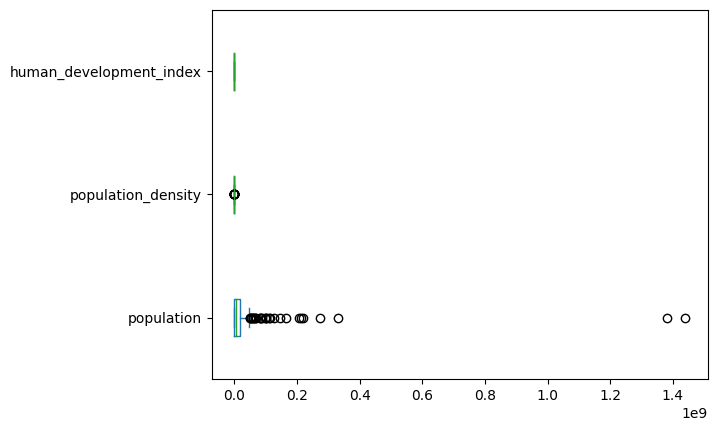

      location_key    population  population_density  human_development_index
6820            CN  1.439324e+09             153.312                    0.752
11574           IN  1.380004e+09             464.149                    0.640

 Epidemiology 
          year    month new_confirmed new_deceased new_recovered   new_tested
count  7647.00  7647.00       7647.00      7647.00       7647.00      7647.00
mean   2020.91     6.09      79566.16       844.98      42769.13    661955.00
std       0.79     3.31     458988.13      4215.28     630888.11   3621963.29
min    2020.00     1.00     -13341.00         0.00   -9906177.00         0.00
25%    2020.00     3.00         64.00         0.00          0.00         0.00
50%    2021.00     6.00       1371.00        11.00          0.00         0.00
75%    2022.00     9.00      17217.50       195.00          0.00     86545.50
max    2022.00    12.00   19597236.00    119560.00   18582607.00  66762647.00


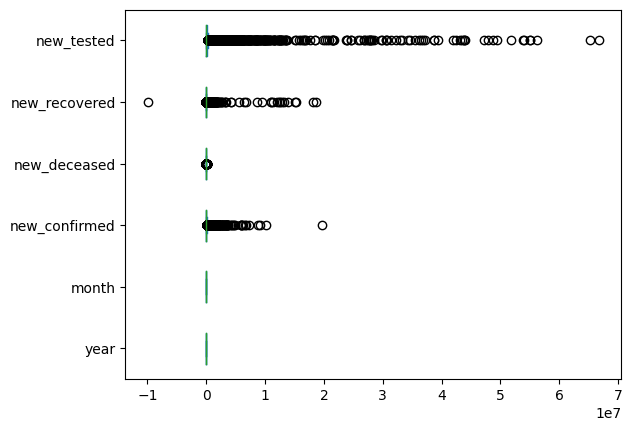


 Hospitalizations 
          year   month new_hospitalized_patients new_intensive_care_patients  \
count   630.00  630.00                    630.00                      630.00   
mean   2020.84    6.21                 321218.44                     1509.87   
std       0.77    3.27                2918771.61                     6054.12   
min    2020.00    1.00                  -6350.00                        0.00   
25%    2020.00    3.00                      0.00                        0.00   
50%    2021.00    6.00                   1260.00                        0.00   
75%    2021.00    9.00                  22028.00                      123.75   
max    2022.00   12.00               58504041.00                    76254.00   

      new_ventilator_patients  
count                  630.00  
mean                     6.80  
std                     51.56  
min                      0.00  
25%                      0.00  
50%                      0.00  
75%                      0.00  
max

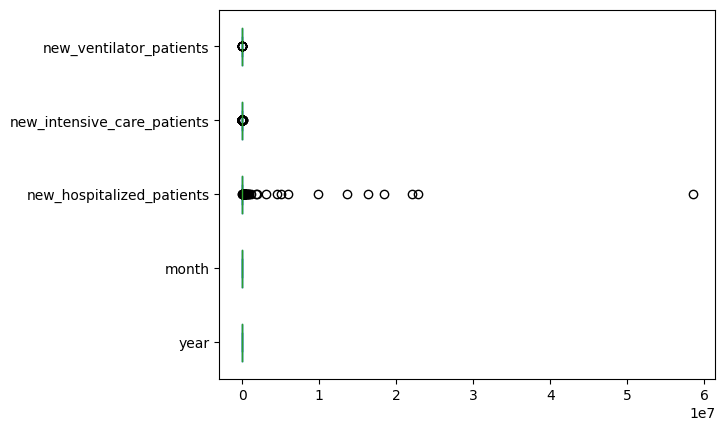


 Vaccinations 
          year    month new_persons_vaccinated new_persons_fully_vaccinated  \
count  3959.00  3959.00                3959.00                      3959.00   
mean   2021.41     6.12             1195761.95                   1044001.35   
std       0.52     3.19             9267772.45                   6254006.81   
min    2020.00     1.00             -518406.00                   -109305.00   
25%    2021.00     3.00                2516.00                      1229.00   
50%    2021.00     6.00               39858.00                     29257.00   
75%    2022.00     9.00              352800.00                    288855.00   
max    2022.00    12.00           450500000.00                 158433000.00   

      new_vaccine_doses_administered  
count                        3959.00  
mean                      3136957.32  
std                      19674264.33  
min                             0.00  
25%                         12181.50  
50%                        149492.00  

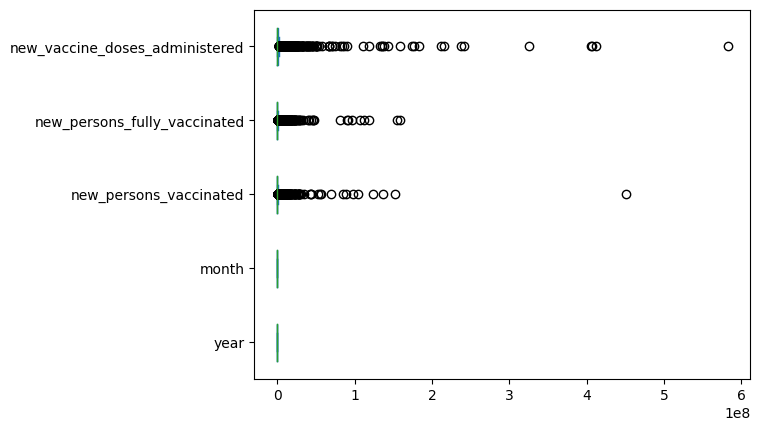


 Health 
      smoking_prevalence diabetes_prevalence infant_mortality_rate  \
count             146.00              209.00                193.00   
mean               21.63                8.36                 21.38   
std                 9.72                4.73                 19.43   
min                 2.00                1.00                  1.40   
25%                14.00                5.40                  6.10   
50%                21.80                6.90                 14.00   
75%                27.98               10.70                 32.70   
max                47.00               30.50                 84.50   

      adult_male_mortality_rate adult_female_mortality_rate  \
count                    199.00                      200.00   
mean                     185.98                      122.49   
std                       93.49                       81.21   
min                       41.50                       24.49   
25%                      111.74             

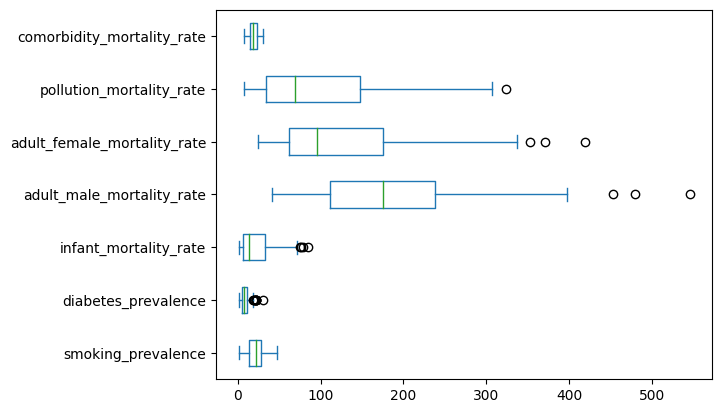


 Economy 
                 gdp_usd gdp_per_capita_usd
count             203.00             203.00
mean     427140770724.73           17989.09
std     1890008781777.86           26649.15
min          47271463.00             261.00
25%        6236429369.00            2257.50
50%       27591261663.00            6966.00
75%      212445406771.50           23192.50
max    21374418877706.00          185829.00


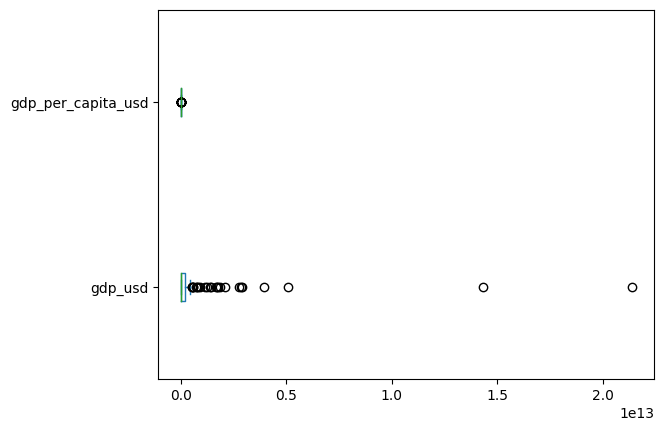

    location_key       gdp_usd  gdp_per_capita_usd
72            CN  1.434290e+13             10261.0
392           US  2.137442e+13             65118.0


In [166]:
for key,values in data.items():
    print("\n\033[1m", key.title(), "\033[0m")
    print(data[key].describe().applymap("{0:.2f}".format))
    data[key].plot.box(vert=False)
    plt.show()
    if key == 'demographics':
        print(data[key][(data[key]['population'] > 1.2e9)])
    if key == 'economy':
        print(data[key][(data[key]['gdp_usd'] > 1.0e13)])
    
    
    

## Combine datasets 

### Check for unique values in simple? datasets 

In [167]:


for key,values in data.items():
    if data[key].columns.isin(['year']).any() == False:        
        print("\n\033[1m", key.title(), "\033[0m")
        key_column = 'location_key'
        print(f"Unique column '{key_column}': {len(data[key][key_column].unique()) == len(data[key])}")       
        

    
    


 Demographics 
Unique column 'location_key': True

 Health 
Unique column 'location_key': True

 Economy 
Unique column 'location_key': True


### Combine datasets

We will take epidemiology as our main dataset, because....

In [168]:
#Main dataset
complete_df = data['epidemiology']
print(len(data['epidemiology']))

for key in [key for key in data.keys() if key not in ['epidemiology']]:
    #If it has year, we will use three keys to do the merge 
    keys_date = ['location_key','year','month']
    keys_without_date = ['location_key']
    if data[key].columns.isin(['year']).any():        
        print("\n\033[1m", key.title(), "\033[0m")
        complete_df = complete_df.merge(data[key], on=keys_date, how="left")
    else:
        print("\n\033[1m", key.title(), "\033[0m")
        complete_df = complete_df.merge(data[key], on=keys_without_date, how="left")

complete_df.head()    

7647

 Demographics 

 Hospitalizations 

 Vaccinations 

 Health 

 Economy 


,year,month,location_key,new_confirmed,new_deceased,new_recovered,new_tested,population,population_density,human_development_index,new_hospitalized_patients,new_intensive_care_patients,new_ventilator_patients,new_persons_vaccinated,new_persons_fully_vaccinated,new_vaccine_doses_administered,smoking_prevalence,diabetes_prevalence,infant_mortality_rate,adult_male_mortality_rate,adult_female_mortality_rate,pollution_mortality_rate,comorbidity_mortality_rate,gdp_usd,gdp_per_capita_usd
0,2020,1,AD,0.0,0.0,0.0,0.0,77265.0,164.394,0.858,NaN,NaN,NaN,NaN,NaN,NaN,33.5,7.7,2.7,NaN,NaN,NaN,NaN,3.154058e+09,40886.0
1,2020,1,AE,9.0,0.0,0.0,258.0,9890400.0,118.306,0.863,NaN,NaN,NaN,NaN,NaN,NaN,28.9,16.3,6.5,69.555,44.863,54.7,16.8,4.211423e+11,43103.0
2,2020,1,AF,0.0,0.0,0.0,0.0,38928341.0,59.627,0.498,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.2,47.9,237.554,192.532,211.1,29.8,1.910135e+10,502.0
3,2020,1,AG,0.0,0.0,0.0,0.0,97928.0,222.564,0.780,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.1,5.0,126.917,83.136,29.9,22.6,1.727759e+09,17790.0
4,2020,1,AI,0.0,0.0,0.0,0.0,15002.0,166.689,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [175]:
complete_df.describe()

,year,month,new_confirmed,new_deceased,new_recovered,new_tested,population,population_density,human_development_index,new_hospitalized_patients,new_intensive_care_patients,new_ventilator_patients,new_persons_vaccinated,new_persons_fully_vaccinated,new_vaccine_doses_administered,smoking_prevalence,diabetes_prevalence,infant_mortality_rate,adult_male_mortality_rate,adult_female_mortality_rate,pollution_mortality_rate,comorbidity_mortality_rate,gdp_usd,gdp_per_capita_usd
count,7647.000000,7647.000000,7.647000e+03,7647.000000,7.647000e+03,7.647000e+03,7.647000e+03,7647.000000,7448.000000,6.300000e+02,630.000000,630.000000,3.953000e+03,3.953000e+03,3.953000e+03,4818.000000,6887.000000,6369.000000,6557.000000,6590.000000,6039.000000,6039.000000,6.689000e+03,6689.000000
mean,2020.909376,6.088008,7.956616e+04,844.976984,4.276913e+04,6.619550e+05,3.348315e+07,459.933536,0.728457,3.212184e+05,1509.873016,6.795238,1.197539e+06,1.045507e+06,3.141229e+06,21.632877,8.366067,21.384974,186.172020,122.635297,92.212568,18.878142,4.275121e+11,17911.393183
std,0.792342,3.305996,4.589881e+05,4215.275171,6.308881e+05,3.621963e+06,1.356786e+08,2263.625714,0.153550,2.918772e+06,6054.116168,51.562218,9.274693e+06,6.258633e+06,1.968889e+07,9.692431,4.723466,19.384526,93.201856,80.991908,71.743619,5.588600,1.886864e+12,26520.712139
min,2020.000000,1.000000,-1.334100e+04,0.000000,-9.906177e+06,0.000000e+00,5.000000e+01,0.138000,0.354000,-6.350000e+03,0.000000,0.000000,-5.184060e+05,-1.093050e+05,0.000000e+00,2.000000,1.000000,1.400000,41.498000,24.487000,7.000000,7.800000,4.727146e+07,261.000000
25%,2020.000000,3.000000,6.400000e+01,0.000000,0.000000e+00,0.000000e+00,4.374830e+05,36.185000,0.612000,0.000000e+00,0.000000,0.000000,2.512000e+03,1.226000e+03,1.215900e+04,14.000000,5.400000,6.100000,110.630000,61.842000,33.500000,14.800000,5.920000e+09,2229.000000
50%,2021.000000,6.000000,1.371000e+03,11.000000,0.000000e+00,0.000000e+00,5.518092e+06,94.400000,0.752000,1.260000e+03,0.000000,0.000000,3.992100e+04,2.905700e+04,1.492730e+05,21.800000,6.900000,14.000000,175.464000,95.764000,68.600000,18.800000,2.759126e+10,6966.000000
75%,2022.000000,9.000000,1.721750e+04,195.000000,0.000000e+00,8.654550e+04,2.141325e+07,235.100000,0.845000,2.202800e+04,123.750000,0.000000,3.529870e+05,2.889220e+05,1.054865e+06,28.000000,10.700000,32.700000,238.333000,176.149000,149.000000,22.900000,2.179620e+11,23246.000000
max,2022.000000,12.000000,1.959724e+07,119560.000000,1.858261e+07,6.676265e+07,1.439324e+09,26338.255000,0.985000,5.850404e+07,76254.000000,467.000000,4.505000e+08,1.584330e+08,5.822410e+08,47.000000,30.500000,84.500000,545.675000,419.363000,324.100000,30.600000,2.137442e+13,185829.000000


In [182]:
correlations = complete_df.corr(numeric_only=True)
correlations

,year,month,new_confirmed,new_deceased,new_recovered,new_tested,population,population_density,human_development_index,new_hospitalized_patients,new_intensive_care_patients,new_ventilator_patients,new_persons_vaccinated,new_persons_fully_vaccinated,new_vaccine_doses_administered,smoking_prevalence,diabetes_prevalence,infant_mortality_rate,adult_male_mortality_rate,adult_female_mortality_rate,pollution_mortality_rate,comorbidity_mortality_rate,gdp_usd,gdp_per_capita_usd
year,1.000000e+00,-1.703575e-01,0.105493,-0.010787,0.029103,0.036014,-0.000124,0.006293,0.000102,0.143539,-0.050488,-0.119457,-0.057638,-0.049930,-0.042202,-2.221185e-15,-0.000206,4.143233e-15,-0.000321,-0.000342,6.752752e-17,-6.794890e-15,-0.000177,0.001611
month,-1.703575e-01,1.000000e+00,-0.035098,0.009174,-0.007715,0.014260,0.000201,-0.006011,-0.000995,-0.006006,-0.029547,0.043900,0.030922,0.059724,0.026118,-1.559821e-16,0.000749,1.470161e-16,0.001262,0.001090,-4.738586e-16,-4.316792e-16,0.000138,-0.001928
new_confirmed,1.054925e-01,-3.509777e-02,1.000000,0.599943,0.225866,0.621667,0.242892,-0.019450,0.123464,0.227145,0.177013,0.233031,0.148798,0.146178,0.146116,3.787263e-02,-0.006209,-1.218362e-01,-0.102248,-0.102844,-1.310603e-01,-1.315623e-01,0.428293,0.085296
new_deceased,-1.078667e-02,9.173957e-03,0.599943,1.000000,0.105902,0.594001,0.302096,-0.029141,0.093054,0.005192,0.581281,0.458625,0.237345,0.208148,0.190149,-7.761566e-04,0.016614,-1.137516e-01,-0.065635,-0.081867,-1.220806e-01,-7.103396e-02,0.456461,0.035881
new_recovered,2.910267e-02,-7.714933e-03,0.225866,0.105902,1.000000,0.200534,0.025088,-0.010653,0.063775,-0.021786,0.185249,-0.029189,0.021024,0.028714,0.017374,6.894514e-02,-0.039431,-6.285266e-02,-0.054345,-0.055387,-7.941347e-02,-9.352743e-02,0.075172,0.045288
new_tested,3.601361e-02,1.425964e-02,0.621667,0.594001,0.200534,1.000000,0.394467,-0.019298,0.123248,-0.007785,0.049106,0.421932,0.344273,0.398388,0.304156,2.156496e-02,0.008065,-1.120626e-01,-0.106155,-0.093578,-1.043259e-01,-1.182691e-01,0.496280,0.107542
population,-1.235742e-04,2.011370e-04,0.242892,0.302096,0.025088,0.394467,1.000000,-0.024589,-0.040168,0.090660,0.308744,0.432875,0.462841,0.579630,0.697912,-4.655987e-02,0.021566,5.011672e-03,-0.037113,-0.014014,9.071138e-02,2.372063e-02,0.578290,-0.063864
population_density,6.293002e-03,-6.011230e-03,-0.019450,-0.029141,-0.010653,-0.019298,-0.024589,1.000000,0.183106,-0.007880,-0.069356,-0.037306,-0.011083,-0.013560,-0.014529,-1.505555e-02,-0.092985,-1.064937e-01,-0.176806,-0.149412,-1.067918e-01,-1.867051e-01,-0.022254,0.481579
human_development_index,1.018002e-04,-9.952456e-04,0.123464,0.093054,0.063775,0.123248,-0.040168,0.183106,1.000000,0.078474,-0.238160,0.101065,-0.004168,-0.001791,0.008662,3.794039e-01,0.157451,-8.864135e-01,-0.762990,-0.830490,-8.694909e-01,-5.782739e-01,0.186735,0.645720
new_hospitalized_patients,1.435387e-01,-6.005901e-03,0.227145,0.005192,-0.021786,-0.007785,0.090660,-0.007880,0.078474,1.000000,-0.019034,-0.005660,-0.018480,-0.017940,0.137799,1.407336e-04,-0.047759,-8.930842e-02,-0.102983,-0.109645,-5.508820e-02,-1.171769e-01,0.076027,-0.004607


<Axes: >

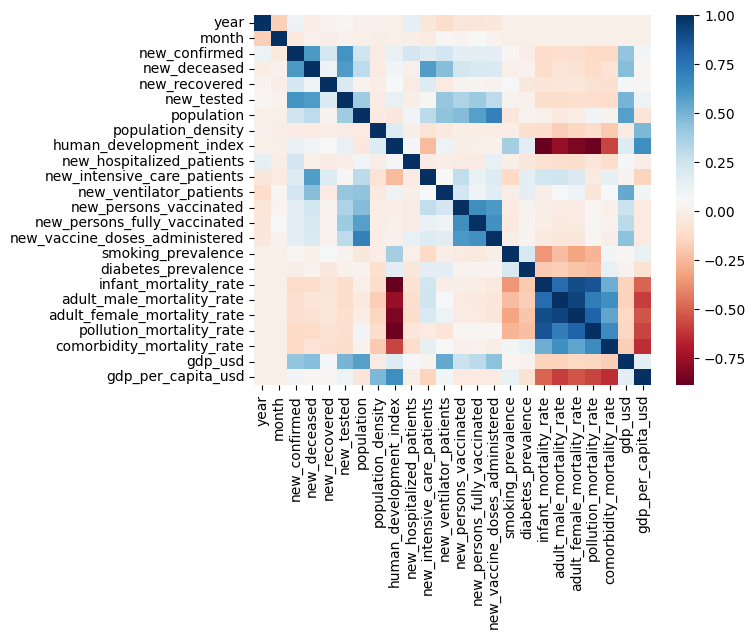

In [183]:
sns.heatmap(correlations, cmap ='RdBu')

In [187]:
correlations[(correlations>0.5) & (correlations!=1)]

,year,month,new_confirmed,new_deceased,new_recovered,new_tested,population,population_density,human_development_index,new_hospitalized_patients,new_intensive_care_patients,new_ventilator_patients,new_persons_vaccinated,new_persons_fully_vaccinated,new_vaccine_doses_administered,smoking_prevalence,diabetes_prevalence,infant_mortality_rate,adult_male_mortality_rate,adult_female_mortality_rate,pollution_mortality_rate,comorbidity_mortality_rate,gdp_usd,gdp_per_capita_usd
year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
new_confirmed,NaN,NaN,NaN,0.599943,NaN,0.621667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
new_deceased,NaN,NaN,0.599943,NaN,NaN,0.594001,NaN,NaN,NaN,NaN,0.581281,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
new_recovered,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
new_tested,NaN,NaN,0.621667,0.594001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
population,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.579630,0.697912,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.57829,NaN
population_density,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
human_development_index,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.64572
new_hospitalized_patients,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
